<div align="center">

# Сжатие данных с учителем с помощью линейного дискриминантного анализа

</div>

---

### Конспект: PCA vs LDA

**Цель уменьшения размерности:**

* PCA (Principal Component Analysis) — без учителя, ищет направления максимальной дисперсии.
* LDA (Linear Discriminant Analysis) — с учителем, ищет проекции, улучшающие разделимость классов.

| Характеристика       | PCA             | LDA                                                 |
| -------------------- | --------------- | --------------------------------------------------- |
| Тип                  | Без учителя     | С учителем                                          |
| Критерий оптимизации | Макс. дисперсии | Макс. межклассовой / мин. внутриклассовой дисперсии |
| Метки классов        | Не нужны        | Обязательны                                         |

**История LDA:**

* 1936: Рональд Фишер предложил дискриминант для двух классов.
* 1948: Радхакришна Рао обобщил метод на многоклассовые задачи при равных ковариациях.

**Когда и как применять:**

* PCA: очистка от шума, визуализация, подготовка данных.
* LDA: финальный шаг для классификации, выделение признаков.
* Комбинация: при небольшом числе образцов сначала PCA (уменьшает шум), затем LDA для повышения точности.

**Ключевые допущения LDA:** нормальное распределение в классах, одинаковые ковариации, независимость примеров. Метод показывает устойчивость даже при частичном нарушении этих условий.




#### Основные шаги LDA с пояснениями

1. **Стандартизация данных**

   * Приводим каждую переменную к среднему 0 и дисперсии 1, чтобы избежать доминирования признаков с большим масштабом.
   * **Формула:**
     $X_{norm} = \frac{X - \mathrm{mean}(X)}{\mathrm{std}(X)}.$

2. **Вычисление средних векторов классов**

   * Для каждого класса $i$ с $N_i$ примерами вычисляем вектор среднего μ\_i:
     $\mu_i = \frac1{N_i} \sum_{x\in D_i} x.$
   * **Зачем?** Эти векторы указывают центры классов и используются при расчёте разбросов.

3. **Построение матриц разброса**

   * **Внутриклассовая матрица $S_W$** — суммирует вариацию внутри каждого класса:
     $S_W = \sum_{i=1}^C \sum_{x\in D_i}(x-\mu_i)(x-\mu_i)^T.$
   * При предположении равномерного распределения меток классов и для стабильности часто нормируют на общее число примеров $N=\sum N_i$. Тогда
     $\Sigma_W = \frac{1}{N}S_W$  совпадает с суммой ковариационных матриц по классам.
   * **Межклассовая матрица $S_B$** — отражает различие между центрами классов:

     $$S_B = \sum_{i=1}^C N_i (\mu_i - \mu)(\mu_i - \mu)^T,\quad
       \mu = \frac{1}{N}\sum_{i=1}^C N_i\mu_i.
     $$
   * **Интерпретация:**

     * Большое $S_W$ означает сильное перекрытие классов.
     * Большое $S_B$ — классы хорошо отделены.

4. **Решение обобщённой задачи собственных значений**

   * Ищем векторы $w$, максимизирующие отношение:
     $w^T S_B w\,/\, w^T S_W w.$
   * Это сводится к решению обобщённой задачи
     $S_W^{-1} S_B w = \lambda w.$
   * **Почему «обобщённая»?** В отличие от PCA здесь две матрицы (меж- и внутриклассовая).

5. **Сортировка дискримиант**

   * Собственные значения λ показывают «дискриминируемость» — вклад каждого направления в разделение классов.
   * Отбираем векторы по убыванию
     $λ_1 \ge λ_2 \ge \dots$  до $C-1$ направлений.

6. **Формирование матрицы преобразования $W$**

   * Складываем $k$ ведущих собственных векторов в столбцы матрицы $W\in\mathbb{R}^{d\times k}$.
   * Ограничение $k\le C-1$ обусловлено рангом $S_B$.

7. **Проекция данных**

   * Применяем линейное преобразование:
     $X' = X_{norm}\,W,$
     где $X_{norm}\in\mathbb{R}^{N\times d}$ — нормализованный набор.
   * В результате получаем $k$ признаков, оптимальных для классификации.
> LDA отличается от PCA тем, что учитывает метки классов через средние векторы (шаг 2).
---

#### Дополнительные замечания

* **Устойчивость к нарушению допущений:** LDA остаётся эффективной, даже если распределения не идеально нормальны или ковариации ligeramente отличаются.
* **Комбинация PCA+LDA:** при малом числе примеров PCA убирает шум, LDA затем находит информативные направления.
* **Коллинеарность:** в случае вырожденного $S_W$ (ранг 1) остаётся единственный ненулевой дискриминант.

---



In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

In [32]:
# Загрузка датасета Wine из репозитория UCI в DataFrame без заголовков
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'wine/wine.data', header=None)

# Назначение имен столбцам для лучшей читаемости и удобства
df_wine.columns = ['Class label',        # Класс вина (1, 2 или 3)
                   'Alcohol',            # Содержание алкоголя
                   'Malic acid',         # Яблочная кислота
                   'Ash',                # Зольность
                   'Alcalinity of ash',  # Щелочность золы
                   'Magnesium',          # Магний
                   'Total phenols',      # Общее количество фенолов
                   'Flavanoids',         # Флавоноиды
                   'Nonflavanoid phenols',       # Нефлавоноидные фенолы
                   'Proanthocyanins',             # Проантоцианы
                   'Color intensity',             # Интенсивность цвета
                   'Hue',                         # Оттенок
                   'OD280/OD315 of diluted wines',# Показатель OD280/OD315
                   'Proline']   

In [33]:
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3,
                     stratify = y,
                     random_state = 0)
# Провести стандартизацию
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)

In [34]:
lda = LDA(n_components = 2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

In [35]:
# Посмотрим как классификатор логистической регрессии 
# обрабатывает набор обучающих данных с низкой размерностью
# после преобразования LDA
lr = OneVsRestClassifier(LogisticRegression(random_state = 1, 
                                            solver = 'lbfgs'))
lr = lr.fit(X_train_lda, y_train)

In [36]:
# График визуализации областей принятия решений
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # Настройка генератора меток и цветной карты
    markers = ('o', 's', '^', 'v', '<')
    colors  = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap    = ListedColormap(colors[:len(np.unique(y))])

    # Построение решающей поверхности
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(
        np.arange(x1_min, x1_max, resolution),
        np.arange(x2_min, x2_max, resolution)
    )
    Z = classifier.predict(np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # Отрисовка всех образцов
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(
            x=X[y == cl, 0],
            y=X[y == cl, 1],
            alpha=0.8,
            c=colors[idx],
            marker=markers[idx],
            label=f'Класс {cl}',
            edgecolor='black'
        )

    # Подсветка тестовых образцов, если переданы индексы
    if test_idx is not None:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(
            X_test[:, 0], X_test[:, 1],
            facecolors='none',
            edgecolors='black',
            alpha=1.0,
            linewidth=1,
            marker='o',
            s=100,
            label='Тестовый набор'
        )

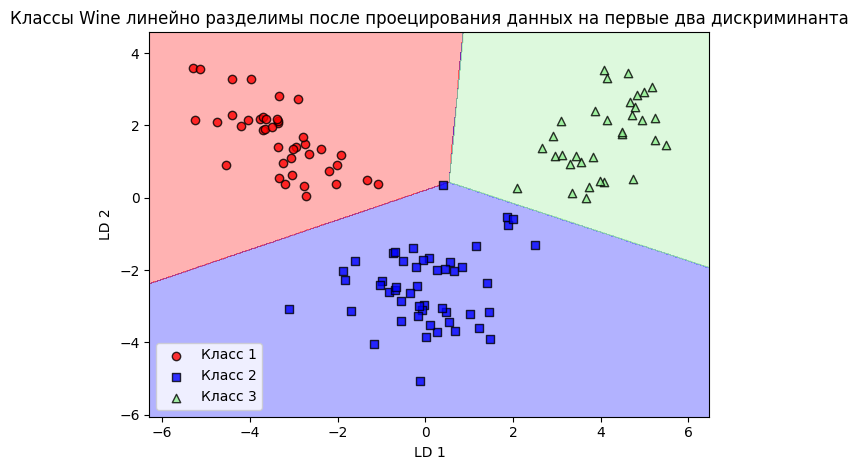

In [37]:
plot_decision_regions(X_train_lda, y_train, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.title('Классы Wine линейно разделимы после проецирования данных на первые два дискриминанта')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

Как видно на рисунке, модель логистической регресии неправильно классифицирует один экземпляр из класса 2.
Снизив степень регуляризации, мы, вероятно, могли бы сдвинуть границы решений,
чтобы модель лоrистической регрессии правильно классифицировала все примеры
в обучающем наборе данных.

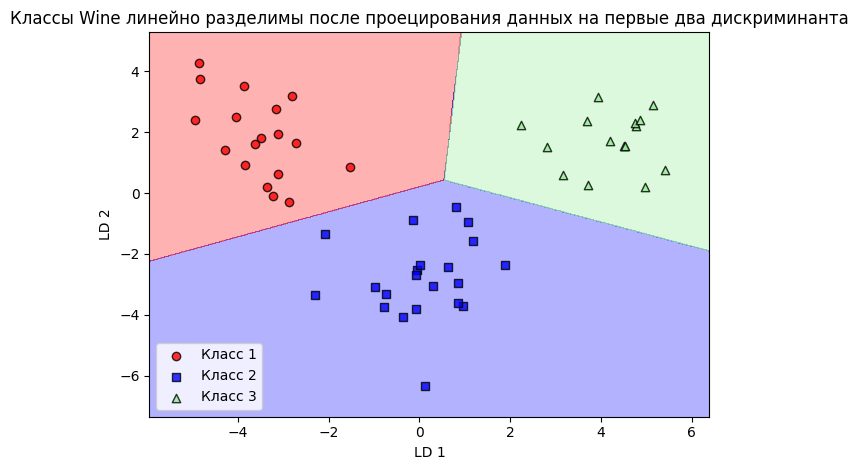

In [38]:
# Посмотрим как классификатор логистической регрессии 
# обрабатывает набор тестовых данных с низкой размерностью
# после преобразования LDA
X_test_lda = lda.transform(X_test_std)
plot_decision_regions(X_test_lda, y_test, classifier = lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.title('Классы Wine линейно разделимы после проецирования данных на первые два дискриминанта')
plt.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

Как видно на рисунке, классификатор логистической регрессии может с идеальной точностью классифицировать экземпляры в тестовом наборе данных, используя только двумерное подпространство вместо исходных 13 признаков Wine.